In [1]:
#Import libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import matplotlib.ticker as ticker

In [2]:
# API Key from EIA
api_key = '4Cgy5BurMNMAhbo0RBIu3s5FFyyo37QEVmW0uBoz'
# PADD Names to Label Columns
# Change to whatever column labels you want to use.
SERIES_NAMES = ['Brent']
# Enter all your Series IDs here separated by commas
SERIES_KEY = ['PET.RBRTE.M']
# Initialize list - this is the final list that you will store all the data from the json pull. Then you will use this list to concat into a pandas dataframe. 
final_data = []
# Choose start and end dates
startDate = '2003-01-01'
endDate = '2022-02-01'


# Pull in data via EIA API
for i in range(len(SERIES_KEY)):
    url = 'http://api.eia.gov/series/?api_key=' + api_key + '&series_id=' + SERIES_KEY[i]
    r = requests.get(url)
    json_data = r.json()
    
    if r.status_code == 200:
        print('Success!')
    else:
        print('Error')
    
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', SERIES_NAMES[i]])
    df.set_index('Date', drop=True, inplace=True)
    final_data.append(df)

Success!


In [3]:
final_data[0]['Year']=final_data[0].index.astype(str).str[:4]
final_data[0]['Month']=final_data[0].index.astype(str).str[4:6]
final_data[0]['Day']='1'#final_data[0].index.astype(str).str[6:]
final_data[0]['Date'] = pd.to_datetime(final_data[0][['Year','Month','Day']])
final_data[0].set_index('Date',drop=True,inplace=True)
final_data[0].sort_index(inplace=True)
final_data[0] = final_data[0][startDate:endDate]
final_data[0] = final_data[0].iloc[:,:5]


In [4]:
## Import inflation data
final_data.append(pd.read_csv('/Users/peter/projects/oil/data/CPIAUCSL.csv'))
final_data[1]['Year']=final_data[1]['DATE'].str[:4]
final_data[1]['Month']=final_data[1]['DATE'].str[5:7]
final_data[1]['Day']=final_data[1]['DATE'].str[8:]
final_data[1]['Date'] = pd.to_datetime(final_data[1][['Year','Month','Day']])
final_data[1].set_index('Date',drop=True,inplace=True)
final_data[1].sort_index(inplace=True)
final_data[1] = final_data[1][startDate:endDate]
final_data[1] = final_data[1].iloc[:,:5]
final_data[1].drop(columns=['DATE'])

final_data[1]['CPIAUCSL']=final_data[1]['CPIAUCSL']/final_data[1]['CPIAUCSL'][-1]

In [5]:


final_data.append(final_data[0].copy())

final_data[2].rename(columns={"Brent":"Inflation Brent"},inplace=True)
final_data[2]['Inflation Brent']=final_data[0]['Brent']/final_data[1]['CPIAUCSL']

final_data[0]=final_data[2].copy()

del final_data[2]
del final_data[1]

crude = pd.concat(final_data,axis=1)

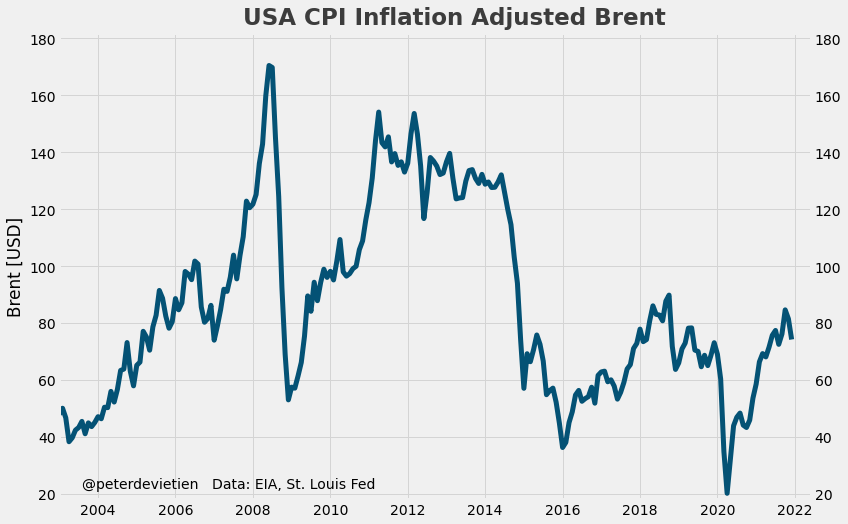

In [6]:


# Generating Colours and Style
colors = {'GLOBAL CONSUMPTION':'#045275','TREND 1':'#DC3977','TREND 2':'#DC3977'}
plt.style.use('fivethirtyeight')


# Creating the Visualization
plot = crude.plot(figsize=(12,8), 
                  color=list(colors.values()), 
                  linewidth=5, 
                  legend=False)



plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_ylabel('Brent [USD]')
plot.set_yticks(range(20,200,20))
plot.set_ylim([18,182])
plot.tick_params(labelright=True)

xdates=[date(2000,1,1),date(2000,1,1) +relativedelta(years=2),date(2000,1,1) +relativedelta(years=4),date(2000,1,1) +relativedelta(years=6),\
date(2000,1,1) +relativedelta(years=8),date(2000,1,1) +relativedelta(years=10),date(2000,1,1) +relativedelta(years=12),date(2000,1,1) +relativedelta(years=14),\
    date(2000,1,1) +relativedelta(years=16),date(2000,1,1) +relativedelta(years=18),date(2000,1,1) +relativedelta(years=20),date(2000,1,1) +relativedelta(years=22)]
xlabels=[]
for i in xdates:
    xlabels.append(i.strftime('%Y'))

plot.set_xticks(xdates)
plot.set_xticklabels(xlabels)
plot.set_xlim([date(2003,1,1),date(2022,6,1)])
plot.set_xlabel('')
#plot.legend({'OECD + non-OECD'},fontsize=22,loc='bottom right')
plot.text(x = date(2007,10,1), 
          y = 185, 
          s = "USA CPI Inflation Adjusted Brent", 
          fontsize = 23, 
          weight = 'bold', 
          alpha = .75)
plot.text(x = date(2003,8,1), 
          y = 22,
          s = '@peterdevietien   Data: EIA, St. Louis Fed', 
          fontsize = 14)

pngname='brent_inflation_adj'
plt.savefig('/Users/peter/projects/oil/post/'+pngname)
